In [2]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, BatchNormalization, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau

def load_data_in_chunks(file_path, chunk_size=1000):
    return pd.read_csv(file_path, engine='python', encoding='utf-8', chunksize=chunk_size)

def preprocess_data(metadata_path, data_path):
    metadata_df = pd.read_csv(metadata_path, sep='\t')
    scRNA_data = pd.concat(load_data_in_chunks(data_path)).transpose()

    # Clean and prepare metadata
    metadata_df.index.rename('cell', inplace=True)
    metadata_df.reset_index(inplace=True)
    metadata_df['cell'] = metadata_df['cell'].astype(str).str.split('-').str[0].str.strip().str.upper()

    # Prepare scRNA data
    scRNA_data.reset_index(inplace=True)
    scRNA_data.rename(columns={'index': 'cell'}, inplace=True)
    scRNA_data['cell'] = scRNA_data['cell'].astype(str).str.split('-').str[0].str.strip().str.upper()

    # Find common cells
    common_cells = set(metadata_df['cell']).intersection(set(scRNA_data['cell']))

    # Filter metadata and scRNA data based on common cells
    filtered_metadata_df = metadata_df[metadata_df['cell'].isin(common_cells)]
    filtered_scRNA_data = scRNA_data[scRNA_data['cell'].isin(common_cells)]

    # Merge metadata with scRNA data
    merged_data = pd.merge(filtered_scRNA_data, filtered_metadata_df[['cell', 'sample_name', 'sample_type']], on='cell', how='inner')
    X = merged_data.drop(columns=['cell', 'sample_name', 'sample_type'])
    y = merged_data['sample_type']
    label_encoder = LabelEncoder()
    y = label_encoder.fit_transform(y)
    return X, y, merged_data, label_encoder

metadata_path = '/scratch/project_2010376/GSE150949_metaData_with_lineage.txt'
data_path = '/scratch/project_2010751/normalized_GSE150949_pc9_count.csv'

X, y, merged_data, label_encoder = preprocess_data(metadata_path, data_path)

# Ensure y is of integer type
y = y.astype(int)

# Debugging prints
print("y dtype:", y.dtype)
print("y unique values:", np.unique(y))

class_counts = np.bincount(y)
plt.figure(figsize=(10, 5))
sns.barplot(x=np.arange(len(class_counts)), y=class_counts)
plt.xlabel('Class')
plt.ylabel('Frequency')
plt.title('Class Distribution')
plt.show()

# Debugging prints
classes = np.unique(y)
print("Classes dtype:", classes.dtype)
print("Classes:", classes)

class_weights = compute_class_weight('balanced', classes=classes, y=y)
class_weight_dict = dict(enumerate(class_weights))

# Debugging prints
print("Class weights:", class_weight_dict)


ModuleNotFoundError: No module named 'tensorflow'

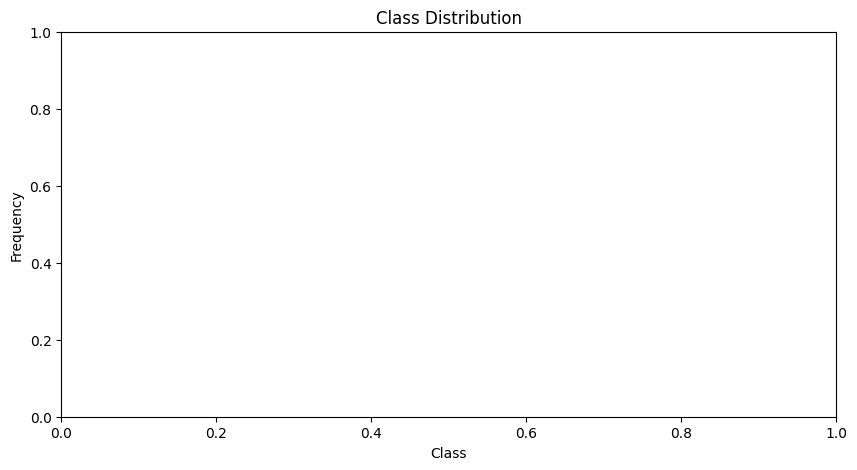

IndexError: arrays used as indices must be of integer (or boolean) type

In [9]:
# Ensure y is of integer type
y = y.astype(int)

class_counts = np.bincount(y)
plt.figure(figsize=(10, 5))
sns.barplot(x=np.arange(len(class_counts)), y=class_counts)
plt.xlabel('Class')
plt.ylabel('Frequency')
plt.title('Class Distribution')
plt.show()

class_weights = compute_class_weight('balanced', classes=np.unique(y), y=y)
class_weight_dict = dict(enumerate(class_weights))


In [4]:
pca = PCA(n_components=500)  # n_components based on available memory and performance
X_reduced = pca.fit_transform(X)

X_train, X_temp, y_train, y_temp = train_test_split(X_reduced, y, test_size=0.2, random_state=42)
X_validation, X_test, y_validation, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_validation = scaler.transform(X_validation)
X_test = scaler.transform(X_test)


In [5]:
def create_complex_autoencoder(input_dim, encoding_dim):
    # Encoder
    input_img = Input(shape=(input_dim,))
    x = Dense(2048, activation='relu')(input_img)
    x = BatchNormalization()(x)
    x = Dropout(0.5)(x)
    x = Dense(1024, activation='relu')(x)
    x = BatchNormalization()(x)
    x = Dropout(0.5)(x)
    x = Dense(512, activation='relu')(x)
    x = BatchNormalization()(x)
    x = Dropout(0.5)(x)
    encoded = Dense(encoding_dim, activation='relu')(x)

    # Decoder
    x = Dense(512, activation='relu')(encoded)
    x = BatchNormalization()(x)
    x = Dropout(0.5)(x)
    x = Dense(1024, activation='relu')(x)
    x = BatchNormalization()(x)
    x = Dropout(0.5)(x)
    x = Dense(2048, activation='relu')(x)
    x = BatchNormalization()(x)
    x = Dropout(0.5)(x)
    decoded = Dense(input_dim, activation='sigmoid')(x)

    # Autoencoder
    autoencoder = Model(input_img, decoded)

    # Encoder model
    encoder = Model(input_img, encoded)

    # Compile autoencoder
    autoencoder.compile(optimizer=Adam(learning_rate=1e-3), loss='mse')

    return autoencoder, encoder

input_dim = X_train.shape[1]
encoding_dim = 256  # Adjusted encoding dimension for detailed encoding

autoencoder, encoder = create_complex_autoencoder(input_dim, encoding_dim)

early_stopping = EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=True)
model_checkpoint = ModelCheckpoint('best_complex_autoencoder.keras', save_best_only=True, monitor='val_loss')
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=10, min_lr=1e-6)

autoencoder.fit(X_train, X_train,
                epochs=300,
                batch_size=256,
                shuffle=True,
                validation_data=(X_validation, X_validation),
                callbacks=[early_stopping, model_checkpoint, reduce_lr])

autoencoder.save('complex_autoencoder_model.keras')
encoder.save('complex_encoder_model.keras')


2024-06-20 16:42:57.804809: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:282] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected


Epoch 1/300
189/189 ━━━━━━━━━━━━━━━━━━━━ 28s 70ms/step - loss: 1.1495 - val_loss: 1.0619 - learning_rate: 0.0010
Epoch 2/300
189/189 ━━━━━━━━━━━━━━━━━━━━ 13s 70ms/step - loss: 1.0118 - val_loss: 1.0290 - learning_rate: 0.0010
Epoch 3/300
189/189 ━━━━━━━━━━━━━━━━━━━━ 21s 81ms/step - loss: 1.0078 - val_loss: 1.0200 - learning_rate: 0.0010
Epoch 4/300
189/189 ━━━━━━━━━━━━━━━━━━━━ 8s 43ms/step - loss: 1.0029 - val_loss: 1.0151 - learning_rate: 0.0010
Epoch 5/300
189/189 ━━━━━━━━━━━━━━━━━━━━ 22s 114ms/step - loss: 1.0042 - val_loss: 1.0145 - learning_rate: 0.0010
Epoch 6/300
189/189 ━━━━━━━━━━━━━━━━━━━━ 8s 42ms/step - loss: 0.9979 - val_loss: 1.0141 - learning_rate: 0.0010
Epoch 7/300
189/189 ━━━━━━━━━━━━━━━━━━━━ 19s 101ms/step - loss: 1.0015 - val_loss: 1.0139 - learning_rate: 0.0010
Epoch 8/300
189/189 ━━━━━━━━━━━━━━━━━━━━ 8s 42ms/step - loss: 1.0006 - val_loss: 1.0137 - learning_rate: 0.0010
Epoch 9/300
189/189 ━━━━━━━━━━━━━━━━━━━━ 15s 80ms/step - loss: 1.0008 - val_loss: 1.0135 - learni

In [6]:
X_train_encoded = encoder.predict(X_train)
X_validation_encoded = encoder.predict(X_validation)
X_test_encoded = encoder.predict(X_test)


1508/1508 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step
189/189 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
189/189 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


In [7]:
def create_ensemble_classifier(input_shape):
    inputs = Input(shape=input_shape)
    x = Dense(512, activation='relu')(inputs)
    x = BatchNormalization()(x)
    x = Dropout(0.5)(x)
    x = Dense(256, activation='relu')(x)
    x = BatchNormalization()(x)
    x = Dropout(0.5)(x)
    x = Dense(128, activation='relu')(x)
    x = BatchNormalization()(x)
    x = Dropout(0.5)(x)
    outputs = Dense(len(np.unique(y_train)), activation='softmax')(x)
    model = Model(inputs=inputs, outputs=outputs)
    return model

input_shape = (encoding_dim,)

classifier = create_ensemble_classifier(input_shape)

optimizer = Adam(learning_rate=1e-4)
classifier.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])

early_stopping = EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True)
model_checkpoint = ModelCheckpoint('best_classifier.keras', save_best_only=True, monitor='val_loss')
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=7, min_lr=1e-6)

classifier.fit(X_train_encoded, y_train,
               epochs=150,
               batch_size=128,
               validation_data=(X_validation_encoded, y_validation),
               class_weight=class_weight_dict,
               callbacks=[early_stopping, model_checkpoint, reduce_lr])

classifier.save('classifier_model.keras')


Epoch 1/150
377/377 ━━━━━━━━━━━━━━━━━━━━ 7s 9ms/step - accuracy: 0.3836 - loss: 1.9653 - val_accuracy: 0.8098 - val_loss: 0.7175 - learning_rate: 1.0000e-04
Epoch 2/150
377/377 ━━━━━━━━━━━━━━━━━━━━ 10s 8ms/step - accuracy: 0.7058 - loss: 1.0188 - val_accuracy: 0.8231 - val_loss: 0.6904 - learning_rate: 1.0000e-04
Epoch 3/150
377/377 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - accuracy: 0.7506 - loss: 0.9078 - val_accuracy: 0.8300 - val_loss: 0.6733 - learning_rate: 1.0000e-04
Epoch 4/150
377/377 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - accuracy: 0.7720 - loss: 0.8389 - val_accuracy: 0.8330 - val_loss: 0.6561 - learning_rate: 1.0000e-04
Epoch 5/150
377/377 ━━━━━━━━━━━━━━━━━━━━ 5s 14ms/step - accuracy: 0.7813 - loss: 0.7861 - val_accuracy: 0.8317 - val_loss: 0.6433 - learning_rate: 1.0000e-04
Epoch 6/150
377/377 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.7915 - loss: 0.7558 - val_accuracy: 0.8357 - val_loss: 0.6263 - learning_rate: 1.0000e-04
Epoch 7/150
377/377 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - a

In [9]:
from sklearn.metrics import classification_report

# Evaluate the classifier on the test set
test_loss, test_accuracy = classifier.evaluate(X_test_encoded, y_test)
print(f"Test Accuracy: {test_accuracy}")

# Predict the test set
y_test_pred = classifier.predict(X_test_encoded).argmax(axis=-1)

# Print the classification report
print(classification_report(y_test, y_test_pred, target_names=label_encoder.classes_))


189/189 ━━━━━━━━━━━━━━━━━━━━ 7s 16ms/step - accuracy: 0.8572 - loss: 0.5054
Test Accuracy: 0.8549402952194214
189/189 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step
              precision    recall  f1-score   support

           0       0.94      0.92      0.93       722
     14_high       0.86      0.88      0.87      1146
      14_low       0.71      0.73      0.72       726
      14_med       0.75      0.71      0.73      1020
           3       0.94      0.93      0.94      1543
           7       0.89      0.90      0.89       875

    accuracy                           0.85      6032
   macro avg       0.85      0.85      0.85      6032
weighted avg       0.85      0.85      0.85      6032



2024-06-24 18:48:53.331533: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-06-24 18:48:56.354048: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-06-24 18:49:21.635090: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


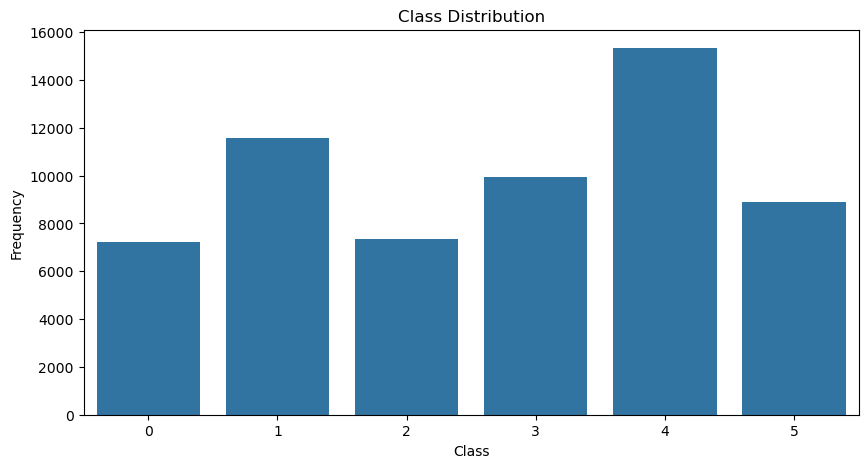

In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, BatchNormalization, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from sklearn.metrics import classification_report

def load_data_in_chunks(file_path, chunk_size=1000):
    return pd.read_csv(file_path, engine='python', encoding='utf-8', chunksize=chunk_size)

def preprocess_data(metadata_path, data_path):
    metadata_df = pd.read_csv(metadata_path, sep='\t')
    scRNA_data = pd.concat(load_data_in_chunks(data_path)).transpose()

    # Clean and prepare metadata
    metadata_df.index.rename('cell', inplace=True)
    metadata_df.reset_index(inplace=True)
    metadata_df['cell'] = metadata_df['cell'].astype(str).str.split('-').str[0].str.strip().str.upper()

    # Prepare scRNA data
    scRNA_data.reset_index(inplace=True)
    scRNA_data.rename(columns={'index': 'cell'}, inplace=True)
    scRNA_data['cell'] = scRNA_data['cell'].astype(str).str.split('-').str[0].str.strip().str.upper()

    # Find common cells
    common_cells = set(metadata_df['cell']).intersection(set(scRNA_data['cell']))

    # Filter metadata and scRNA data based on common cells
    filtered_metadata_df = metadata_df[metadata_df['cell'].isin(common_cells)]
    filtered_scRNA_data = scRNA_data[scRNA_data['cell'].isin(common_cells)]

    # Merge metadata with scRNA data
    merged_data = pd.merge(filtered_scRNA_data, filtered_metadata_df[['cell', 'sample_name', 'sample_type']], on='cell', how='inner')
    X = merged_data.drop(columns=['cell', 'sample_name', 'sample_type'])
    y = merged_data['sample_type']
    label_encoder = LabelEncoder()
    y = label_encoder.fit_transform(y)
    return X, y, merged_data, label_encoder

metadata_path = '/users/barmanjy/Desktop/Persister Cell 2/GSE150949_metaData_with_lineage.txt'
data_path = '/users/barmanjy/Desktop/Persister Cell 2/GSE150949_pc9_count_matrix.csv'

X, y, merged_data, label_encoder = preprocess_data(metadata_path, data_path)

class_counts = np.bincount(y)
plt.figure(figsize=(10, 5))
sns.barplot(x=np.arange(len(class_counts)), y=class_counts)
plt.xlabel('Class')
plt.ylabel('Frequency')
plt.title('Class Distribution')
plt.show()






Unique sample types: ['0' '7' '3' '14_high' '14_med' '14_low']
Sample type distribution:
 sample_type
3          15338
14_high    11571
14_med      9931
7           8891
14_low      7358
0           7226
Name: count, dtype: int64
Merged data shape: (60315, 22169)
First few rows of merged data:
                cell  0  1  2  3  4  5  6  7  8  ... 22158 22159 22160 22161  \
0  AAACCTGAGACAAGCC  0  0  0  0  0  0  0  0  0  ...     0     0     0     0   
1  AAACCTGAGCAGACTG  0  0  0  0  0  0  0  0  0  ...     0     0     0     0   
2  AAACCTGAGCGAGAAA  0  0  0  0  0  0  0  0  0  ...     0     0     0     0   
3  AAACCTGAGGACAGAA  0  0  0  0  0  0  0  0  0  ...     0     0     0     0   
4  AAACCTGAGGCCGAAT  0  0  0  1  0  0  0  0  0  ...     0     0     0     0   

  22162 22163 22164 22165 sample_name sample_type  
0     0     0     0     0           0           0  
1     0     0     0     0           0           0  
2     0     0     0     0           0           0  
3     0     0     0  

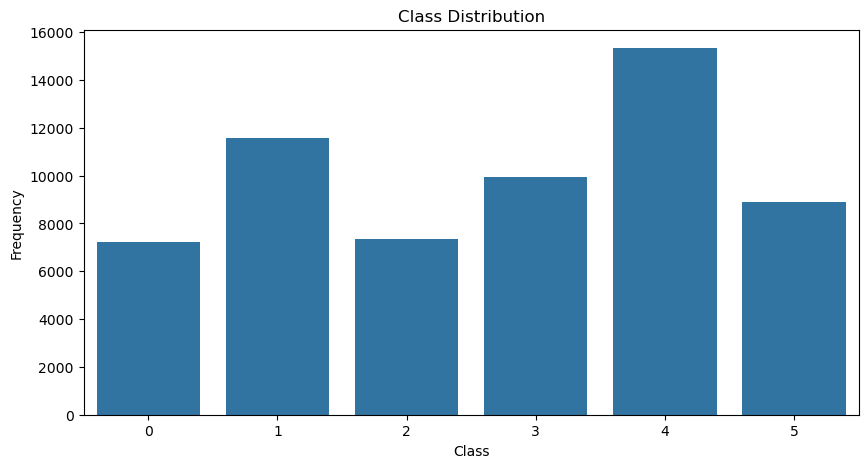

Unique values in y_model1: (array([0, 1]), array([ 7226, 53089]))


2024-06-24 21:18:41.934635: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:282] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected


Epoch 1/300
332/332 ━━━━━━━━━━━━━━━━━━━━ 17s 39ms/step - loss: 1.1086 - val_loss: 1.0346 - learning_rate: 0.0010
Epoch 2/300
332/332 ━━━━━━━━━━━━━━━━━━━━ 13s 38ms/step - loss: 1.0069 - val_loss: 1.0130 - learning_rate: 0.0010
Epoch 3/300
332/332 ━━━━━━━━━━━━━━━━━━━━ 13s 38ms/step - loss: 1.0008 - val_loss: 1.0095 - learning_rate: 0.0010
Epoch 4/300
332/332 ━━━━━━━━━━━━━━━━━━━━ 13s 38ms/step - loss: 1.0017 - val_loss: 1.0064 - learning_rate: 0.0010
Epoch 5/300
332/332 ━━━━━━━━━━━━━━━━━━━━ 13s 38ms/step - loss: 0.9926 - val_loss: 1.0037 - learning_rate: 0.0010
Epoch 6/300
332/332 ━━━━━━━━━━━━━━━━━━━━ 13s 38ms/step - loss: 0.9936 - val_loss: 1.0013 - learning_rate: 0.0010
Epoch 7/300
332/332 ━━━━━━━━━━━━━━━━━━━━ 13s 39ms/step - loss: 0.9884 - val_loss: 0.9989 - learning_rate: 0.0010
Epoch 8/300
332/332 ━━━━━━━━━━━━━━━━━━━━ 13s 38ms/step - loss: 0.9865 - val_loss: 0.9965 - learning_rate: 0.0010
Epoch 9/300
332/332 ━━━━━━━━━━━━━━━━━━━━ 13s 39ms/step - loss: 0.9879 - val_loss: 0.9942 - learn

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



305/305 ━━━━━━━━━━━━━━━━━━━━ 12s 39ms/step - loss: 0.9889 - val_loss: 0.9917 - learning_rate: 0.0010
Epoch 12/300
305/305 ━━━━━━━━━━━━━━━━━━━━ 12s 38ms/step - loss: 0.9932 - val_loss: 0.9899 - learning_rate: 0.0010
Epoch 13/300
305/305 ━━━━━━━━━━━━━━━━━━━━ 12s 38ms/step - loss: 0.9857 - val_loss: 0.9883 - learning_rate: 0.0010
Epoch 14/300
305/305 ━━━━━━━━━━━━━━━━━━━━ 12s 38ms/step - loss: 0.9855 - val_loss: 0.9866 - learning_rate: 0.0010
Epoch 15/300
305/305 ━━━━━━━━━━━━━━━━━━━━ 12s 38ms/step - loss: 0.9874 - val_loss: 0.9852 - learning_rate: 0.0010
Epoch 16/300
305/305 ━━━━━━━━━━━━━━━━━━━━ 12s 38ms/step - loss: 0.9818 - val_loss: 0.9834 - learning_rate: 0.0010
Epoch 17/300
305/305 ━━━━━━━━━━━━━━━━━━━━ 12s 38ms/step - loss: 0.9809 - val_loss: 0.9822 - learning_rate: 0.0010
Epoch 18/300
305/305 ━━━━━━━━━━━━━━━━━━━━ 12s 39ms/step - loss: 0.9802 - val_loss: 0.9799 - learning_rate: 0.0010
Epoch 19/300
305/305 ━━━━━━━━━━━━━━━━━━━━ 12s 39ms/step - loss: 0.9794 - val_loss: 0.9786 - learning_

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



305/305 ━━━━━━━━━━━━━━━━━━━━ 12s 39ms/step - loss: 0.9570 - val_loss: 0.9555 - learning_rate: 0.0010
Epoch 51/300
305/305 ━━━━━━━━━━━━━━━━━━━━ 12s 39ms/step - loss: 0.9578 - val_loss: 0.9552 - learning_rate: 0.0010
Epoch 52/300
305/305 ━━━━━━━━━━━━━━━━━━━━ 12s 39ms/step - loss: 0.9589 - val_loss: 0.9545 - learning_rate: 0.0010
Epoch 53/300
305/305 ━━━━━━━━━━━━━━━━━━━━ 12s 38ms/step - loss: 0.9566 - val_loss: 0.9546 - learning_rate: 0.0010
Epoch 54/300
305/305 ━━━━━━━━━━━━━━━━━━━━ 12s 39ms/step - loss: 0.9564 - val_loss: 0.9540 - learning_rate: 0.0010
Epoch 55/300
305/305 ━━━━━━━━━━━━━━━━━━━━ 12s 38ms/step - loss: 0.9548 - val_loss: 0.9544 - learning_rate: 0.0010
Epoch 56/300
305/305 ━━━━━━━━━━━━━━━━━━━━ 12s 39ms/step - loss: 0.9558 - val_loss: 0.9532 - learning_rate: 0.0010
Epoch 57/300
305/305 ━━━━━━━━━━━━━━━━━━━━ 11s 37ms/step - loss: 0.9591 - val_loss: 0.9534 - learning_rate: 0.0010
Epoch 58/300
305/305 ━━━━━━━━━━━━━━━━━━━━ 12s 38ms/step - loss: 0.9570 - val_loss: 0.9533 - learning_

In [ ]:
from imblearn.over_sampling import SMOTE
print("Unique sample types:", merged_data['sample_type'].unique())
print("Sample type distribution:\n", merged_data['sample_type'].value_counts())
print("Merged data shape:", merged_data.shape)
print("First few rows of merged data:\n", merged_data.head())

class_counts = np.bincount(y)
plt.figure(figsize=(10, 5))
sns.barplot(x=np.arange(len(class_counts)), y=class_counts)
plt.xlabel('Class')
plt.ylabel('Frequency')
plt.title('Class Distribution')
plt.show()

class_weights = compute_class_weight('balanced', classes=np.unique(y), y=y)
class_weight_dict = dict(enumerate(class_weights))

pca = PCA(n_components=500)  # n_components based on available memory and performance
X_reduced = pca.fit_transform(X)

def create_complex_autoencoder(input_dim, encoding_dim):
    # Encoder
    input_img = Input(shape=(input_dim,))
    x = Dense(2048, activation='relu')(input_img)
    x = BatchNormalization()(x)
    x = Dropout(0.5)(x)
    x = Dense(1024, activation='relu')(x)
    x = BatchNormalization()(x)
    x = Dropout(0.5)(x)
    x = Dense(512, activation='relu')(x)
    x = BatchNormalization()(x)
    x = Dropout(0.5)(x)
    encoded = Dense(encoding_dim, activation='relu')(x)

    # Decoder
    x = Dense(512, activation='relu')(encoded)
    x = BatchNormalization()(x)
    x = Dropout(0.5)(x)
    x = Dense(1024, activation='relu')(x)
    x = BatchNormalization()(x)
    x = Dropout(0.5)(x)
    x = Dense(2048, activation='relu')(x)
    x = BatchNormalization()(x)
    x = Dropout(0.5)(x)
    decoded = Dense(input_dim, activation='sigmoid')(x)

    # Autoencoder
    autoencoder = Model(input_img, decoded)

    # Encoder model
    encoder = Model(input_img, encoded)

    # Compile autoencoder
    autoencoder.compile(optimizer=Adam(learning_rate=1e-3), loss='mse')

    return autoencoder, encoder

def create_ensemble_classifier(input_shape):
    inputs = Input(shape=input_shape)
    x = Dense(512, activation='relu')(inputs)
    x = BatchNormalization()(x)
    x = Dropout(0.5)(x)
    x = Dense(256, activation='relu')(x)
    x = BatchNormalization()(x)
    x = Dropout(0.5)(x)
    x = Dense(128, activation='relu')(x)
    x = BatchNormalization()(x)
    x = Dropout(0.5)(x)
    outputs = Dense(2, activation='softmax')(x)
    model = Model(inputs=inputs, outputs=outputs)
    return model

def model_1():
    # Define the mappings based on sample_type
    non_persister_samples = [0]
    persister_samples = ["7","3","14_high","14_med","14_low"]

    # Update labels: 0 = non-persister, 1 = persister
    y_model1 = np.where(merged_data['sample_type'].isin(persister_samples), 1, 0)

    # Debug statements to check the unique values and their counts
    print("Unique values in y_model1:", np.unique(y_model1, return_counts=True))

    # Ensure there are samples for both classes
    if len(np.unique(y_model1)) != 2:
        print("Not enough classes in y_model1 for Model 1")
        return

    # Oversample the minority class using SMOTE
    smote = SMOTE(random_state=42)
    X_resampled, y_resampled = smote.fit_resample(X_reduced, y_model1)

    # Split the data
    X_train, X_temp, y_train, y_temp = train_test_split(X_resampled, y_resampled, test_size=0.2, random_state=42)
    X_validation, X_test, y_validation, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

    # Scale the data
    scaler = StandardScaler()
    X_train = scaler.fit_transform(X_train)
    X_validation = scaler.transform(X_validation)
    X_test = scaler.transform(X_test)

    # Create and train the autoencoder
    autoencoder, encoder = create_complex_autoencoder(X_train.shape[1], 256)

    early_stopping = EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=True)
    model_checkpoint = ModelCheckpoint('best_complex_autoencoder_model1.keras', save_best_only=True, monitor='val_loss')
    reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=10, min_lr=1e-6)

    autoencoder.fit(X_train, X_train,
                    epochs=300,
                    batch_size=256,
                    shuffle=True,
                    validation_data=(X_validation, X_validation),
                    callbacks=[early_stopping, model_checkpoint, reduce_lr])

    autoencoder.save('complex_autoencoder_model1.keras')
    encoder.save('complex_encoder_model1.keras')

    X_train_encoded = encoder.predict(X_train)
    X_validation_encoded = encoder.predict(X_validation)
    X_test_encoded = encoder.predict(X_test)

    # Create and train the classifier
    classifier = create_ensemble_classifier((256,))

    classifier.compile(optimizer=Adam(learning_rate=1e-4), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

    early_stopping = EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True)
    model_checkpoint = ModelCheckpoint('best_classifier_model1.keras', save_best_only=True, monitor='val_loss')
    reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=7, min_lr=1e-6)

    classifier.fit(X_train_encoded, y_train,
                   epochs=150,
                   batch_size=128,
                   validation_data=(X_validation_encoded, y_validation),
                   class_weight=class_weight_dict,
                   callbacks=[early_stopping, model_checkpoint, reduce_lr])

    classifier.save('classifier_model1.keras')

    # Evaluate the classifier on the test set
    test_loss, test_accuracy = classifier.evaluate(X_test_encoded, y_test)
    print(f"Test Accuracy: {test_accuracy}")

    # Predict the test set
    y_test_pred = classifier.predict(X_test_encoded).argmax(axis=-1)

    # Ensure there are two classes in the target names
    if len(np.unique(y_test_pred)) == 2:
        print(classification_report(y_test, y_test_pred, target_names=['Non-Persister', 'Persister']))
    else:
        print(f"Only one class {np.unique(y_test_pred)[0]} predicted, classification report is not generated.")

def model_2():
    # Define the mappings based on sample_type
    group1_samples = ["14_high"]  # Dint divide
    group2_samples = ["14_med", "14_low"]  # Divide

    # Update labels: 0 = Group1 (Dint divide), 1 = Group2 (Divide)
    y_model2 = np.where(merged_data['sample_type'].isin(group1_samples), 0, 1)

    # Debug statements to check the unique values and their counts
    print("Unique values in y_model2:", np.unique(y_model2, return_counts=True))

    # Ensure there are samples for both classes
    if len(np.unique(y_model2)) != 2:
        print("Not enough classes in y_model2 for Model 2")
        return

    # Oversample the minority class using SMOTE
    smote = SMOTE(random_state=42)
    X_resampled, y_resampled = smote.fit_resample(X_reduced, y_model2)

    # Split the data
    X_train, X_temp, y_train, y_temp = train_test_split(X_resampled, y_resampled, test_size=0.2, random_state=42)
    X_validation, X_test, y_validation, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

    # Scale the data
    scaler = StandardScaler()
    X_train = scaler.fit_transform(X_train)
    X_validation = scaler.transform(X_validation)
    X_test = scaler.transform(X_test)

    # Create and train the autoencoder
    autoencoder, encoder = create_complex_autoencoder(X_train.shape[1], 256)

    early_stopping = EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=True)
    model_checkpoint = ModelCheckpoint('best_complex_autoencoder_model2.keras', save_best_only=True, monitor='val_loss')
    reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=10, min_lr=1e-6)

    autoencoder.fit(X_train, X_train,
                    epochs=300,
                    batch_size=256,
                    shuffle=True,
                    validation_data=(X_validation, X_validation),
                    callbacks=[early_stopping, model_checkpoint, reduce_lr])

    autoencoder.save('complex_autoencoder_model2.keras')
    encoder.save('complex_encoder_model2.keras')

    X_train_encoded = encoder.predict(X_train)
    X_validation_encoded = encoder.predict(X_validation)
    X_test_encoded = encoder.predict(X_test)

    # Create and train the classifier
    classifier = create_ensemble_classifier((256,))

    classifier.compile(optimizer=Adam(learning_rate=1e-4), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

    early_stopping = EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True)
    model_checkpoint = ModelCheckpoint('best_classifier_model2.keras', save_best_only=True, monitor='val_loss')
    reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=7, min_lr=1e-6)

    classifier.fit(X_train_encoded, y_train,
                   epochs=150,
                   batch_size=128,
                   validation_data=(X_validation_encoded, y_validation),
                   class_weight=class_weight_dict,
                   callbacks=[early_stopping, model_checkpoint, reduce_lr])

    classifier.save('classifier_model2.keras')

    # Evaluate the classifier on the test set
    test_loss, test_accuracy = classifier.evaluate(X_test_encoded, y_test)
    print(f"Test Accuracy: {test_accuracy}")

    # Predict the test set
    y_test_pred = classifier.predict(X_test_encoded).argmax(axis=-1)

    # Ensure there are two classes in the target names
    if len(np.unique(y_test_pred)) == 2:
        print(classification_report(y_test, y_test_pred, target_names=['Group1 (Dint divide)', 'Group2 (Divide)']))
    else:
        print(f"Only one class {np.unique(y_test_pred)[0]} predicted, classification report is not generated.")

# Execute Model 1
model_1()

# Execute Model 2
model_2()

In [ ]:
model_2()

Unique values in y_model2: (array([0, 1]), array([11571, 48744]))
Epoch 1/300
305/305 ━━━━━━━━━━━━━━━━━━━━ 19s 40ms/step - loss: 1.1159 - val_loss: 1.0473 - learning_rate: 0.0010
Epoch 2/300
305/305 ━━━━━━━━━━━━━━━━━━━━ 12s 39ms/step - loss: 1.0088 - val_loss: 1.0067 - learning_rate: 0.0010
Epoch 3/300
305/305 ━━━━━━━━━━━━━━━━━━━━ 12s 39ms/step - loss: 1.0048 - val_loss: 1.0042 - learning_rate: 0.0010
Epoch 4/300
305/305 ━━━━━━━━━━━━━━━━━━━━ 12s 39ms/step - loss: 1.0001 - val_loss: 1.0037 - learning_rate: 0.0010
Epoch 5/300
305/305 ━━━━━━━━━━━━━━━━━━━━ 12s 39ms/step - loss: 0.9974 - val_loss: 1.0035 - learning_rate: 0.0010
Epoch 6/300
305/305 ━━━━━━━━━━━━━━━━━━━━ 12s 39ms/step - loss: 0.9990 - val_loss: 1.0030 - learning_rate: 0.0010
Epoch 7/300
305/305 ━━━━━━━━━━━━━━━━━━━━ 12s 39ms/step - loss: 1.0000 - val_loss: 1.0023 - learning_rate: 0.0010
Epoch 8/300
305/305 ━━━━━━━━━━━━━━━━━━━━ 13s 43ms/step - loss: 0.9999 - val_loss: 1.0010 - learning_rate: 0.0010
Epoch 9/300
305/305 ━━━━━━━━━━

In [ ]:
model_1()

332/332 ━━━━━━━━━━━━━━━━━━━━ 13s 38ms/step - loss: 0.9426 - val_loss: 0.9430 - learning_rate: 5.0000e-04
Epoch 131/300
332/332 ━━━━━━━━━━━━━━━━━━━━ 13s 39ms/step - loss: 0.9435 - val_loss: 0.9424 - learning_rate: 5.0000e-04
Epoch 132/300
332/332 ━━━━━━━━━━━━━━━━━━━━ 14s 42ms/step - loss: 0.9430 - val_loss: 0.9428 - learning_rate: 5.0000e-04
Epoch 133/300
332/332 ━━━━━━━━━━━━━━━━━━━━ 13s 39ms/step - loss: 0.9386 - val_loss: 0.9424 - learning_rate: 5.0000e-04
Epoch 134/300
332/332 ━━━━━━━━━━━━━━━━━━━━ 13s 38ms/step - loss: 0.9412 - val_loss: 0.9431 - learning_rate: 5.0000e-04
Epoch 135/300
332/332 ━━━━━━━━━━━━━━━━━━━━ 13s 38ms/step - loss: 0.9424 - val_loss: 0.9427 - learning_rate: 5.0000e-04
Epoch 136/300
332/332 ━━━━━━━━━━━━━━━━━━━━ 13s 38ms/step - loss: 0.9460 - val_loss: 0.9426 - learning_rate: 5.0000e-04
Epoch 137/300
332/332 ━━━━━━━━━━━━━━━━━━━━ 13s 38ms/step - loss: 0.9442 - val_loss: 0.9425 - learning_rate: 5.0000e-04
Epoch 138/300
332/332 ━━━━━━━━━━━━━━━━━━━━ 13s 39ms/step - los

2024-06-25 05:59:20.057247: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-06-25 05:59:24.049476: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-06-25 05:59:49.715367: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


Unique sample types: ['0' '7' '3' '14_high' '14_med' '14_low']
Sample type distribution:
 sample_type
3          15338
14_high    11571
14_med      9931
7           8891
14_low      7358
0           7226
Name: count, dtype: int64
Merged data shape: (60315, 22169)
First few rows of merged data:
                cell  0  1  2  3  4  5  6  7  8  ... 22158 22159 22160 22161  \
0  AAACCTGAGACAAGCC  0  0  0  0  0  0  0  0  0  ...     0     0     0     0   
1  AAACCTGAGCAGACTG  0  0  0  0  0  0  0  0  0  ...     0     0     0     0   
2  AAACCTGAGCGAGAAA  0  0  0  0  0  0  0  0  0  ...     0     0     0     0   
3  AAACCTGAGGACAGAA  0  0  0  0  0  0  0  0  0  ...     0     0     0     0   
4  AAACCTGAGGCCGAAT  0  0  0  1  0  0  0  0  0  ...     0     0     0     0   

  22162 22163 22164 22165 sample_name sample_type  
0     0     0     0     0           0           0  
1     0     0     0     0           0           0  
2     0     0     0     0           0           0  
3     0     0     0  

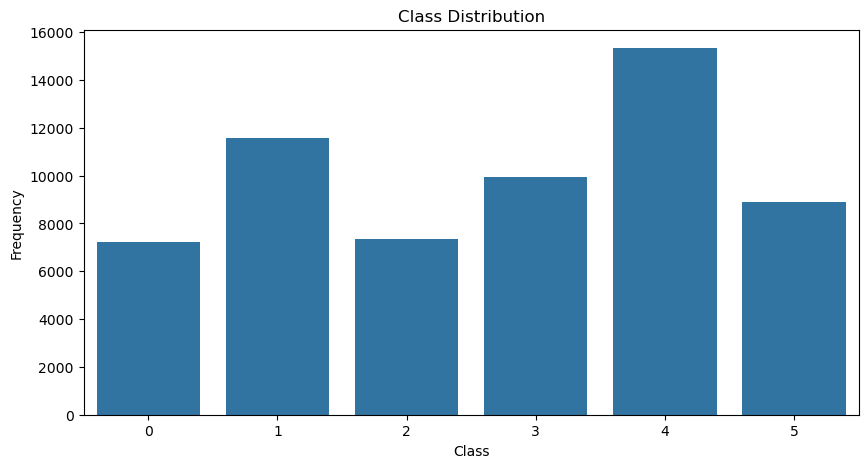

Unique values in y_model1: (array([0, 1]), array([ 7226, 53089]))


2024-06-25 06:17:45.845859: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:282] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected


Epoch 1/300
664/664 - 22s - 33ms/step - loss: 1.0328 - val_loss: 1.0142 - learning_rate: 0.0010
Epoch 2/300
664/664 - 18s - 27ms/step - loss: 0.9987 - val_loss: 1.0078 - learning_rate: 0.0010
Epoch 3/300
664/664 - 18s - 27ms/step - loss: 0.9946 - val_loss: 1.0047 - learning_rate: 0.0010
Epoch 4/300
664/664 - 18s - 27ms/step - loss: 0.9921 - val_loss: 1.0017 - learning_rate: 0.0010
Epoch 5/300
664/664 - 18s - 28ms/step - loss: 0.9895 - val_loss: 0.9990 - learning_rate: 0.0010
Epoch 6/300
664/664 - 18s - 28ms/step - loss: 0.9871 - val_loss: 0.9974 - learning_rate: 0.0010
Epoch 7/300
664/664 - 19s - 28ms/step - loss: 0.9853 - val_loss: 0.9935 - learning_rate: 0.0010
Epoch 8/300
664/664 - 19s - 28ms/step - loss: 0.9832 - val_loss: 0.9914 - learning_rate: 0.0010
Epoch 9/300
664/664 - 19s - 28ms/step - loss: 0.9820 - val_loss: 0.9906 - learning_rate: 0.0010
Epoch 10/300
664/664 - 19s - 28ms/step - loss: 0.9804 - val_loss: 0.9886 - learning_rate: 0.0010
Epoch 11/300
664/664 - 18s - 28ms/step 

In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight
from imblearn.over_sampling import SMOTE
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, BatchNormalization, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from sklearn.metrics import classification_report

def load_data_in_chunks(file_path, chunk_size=1000):
    return pd.read_csv(file_path, engine='python', encoding='utf-8', chunksize=chunk_size)

def preprocess_data(metadata_path, data_path):
    metadata_df = pd.read_csv(metadata_path, sep='\t')
    scRNA_data = pd.concat(load_data_in_chunks(data_path)).transpose()

    # Clean and prepare metadata
    metadata_df.index.rename('cell', inplace=True)
    metadata_df.reset_index(inplace=True)
    metadata_df['cell'] = metadata_df['cell'].astype(str).str.split('-').str[0].str.strip().str.upper()

    # Prepare scRNA data
    scRNA_data.reset_index(inplace=True)
    scRNA_data.rename(columns={'index': 'cell'}, inplace=True)
    scRNA_data['cell'] = scRNA_data['cell'].astype(str).str.split('-').str[0].str.strip().str.upper()

    # Find common cells
    common_cells = set(metadata_df['cell']).intersection(set(scRNA_data['cell']))

    # Filter metadata and scRNA data based on common cells
    filtered_metadata_df = metadata_df[metadata_df['cell'].isin(common_cells)]
    filtered_scRNA_data = scRNA_data[scRNA_data['cell'].isin(common_cells)]

    # Merge metadata with scRNA data
    merged_data = pd.merge(filtered_scRNA_data, filtered_metadata_df[['cell', 'sample_name', 'sample_type']], on='cell', how='inner')
    X = merged_data.drop(columns=['cell', 'sample_name', 'sample_type'])
    y = merged_data['sample_type']
    label_encoder = LabelEncoder()
    y = label_encoder.fit_transform(y)
    return X, y, merged_data, label_encoder

metadata_path = '/users/barmanjy/Desktop/Persister Cell 2/GSE150949_metaData_with_lineage.txt'
data_path = '/users/barmanjy/Desktop/Persister Cell 2/GSE150949_pc9_count_matrix.csv'

X, y, merged_data, label_encoder = preprocess_data(metadata_path, data_path)

# Debugging steps to verify data
print("Unique sample types:", merged_data['sample_type'].unique())
print("Sample type distribution:\n", merged_data['sample_type'].value_counts())
print("Merged data shape:", merged_data.shape)
print("First few rows of merged data:\n", merged_data.head())

class_counts = np.bincount(y)
plt.figure(figsize=(10, 5))
sns.barplot(x=np.arange(len(class_counts)), y=class_counts)
plt.xlabel('Class')
plt.ylabel('Frequency')
plt.title('Class Distribution')
plt.show()

class_weights = compute_class_weight('balanced', classes=np.unique(y), y=y)
class_weight_dict = dict(enumerate(class_weights))

pca = PCA(n_components=500)  # n_components based on available memory and performance
X_reduced = pca.fit_transform(X)

def create_complex_autoencoder(input_dim, encoding_dim):
    # Encoder
    input_img = Input(shape=(input_dim,))
    x = Dense(2048, activation='relu')(input_img)
    x = BatchNormalization()(x)
    x = Dropout(0.5)(x)
    x = Dense(1024, activation='relu')(x)
    x = BatchNormalization()(x)
    x = Dropout(0.5)(x)
    x = Dense(512, activation='relu')(x)
    x = BatchNormalization()(x)
    x = Dropout(0.5)(x)
    encoded = Dense(encoding_dim, activation='relu')(x)

    # Decoder
    x = Dense(512, activation='relu')(encoded)
    x = BatchNormalization()(x)
    x = Dropout(0.5)(x)
    x = Dense(1024, activation='relu')(x)
    x = BatchNormalization()(x)
    x = Dropout(0.5)(x)
    x = Dense(2048, activation='relu')(x)
    x = BatchNormalization()(x)
    x = Dropout(0.5)(x)
    decoded = Dense(input_dim, activation='sigmoid')(x)

    # Autoencoder
    autoencoder = Model(input_img, decoded)

    # Encoder model
    encoder = Model(input_img, encoded)

    # Compile autoencoder
    autoencoder.compile(optimizer=Adam(learning_rate=1e-3), loss='mse')

    return autoencoder, encoder

def create_ensemble_classifier(input_shape):
    inputs = Input(shape=input_shape)
    x = Dense(512, activation='relu')(inputs)
    x = BatchNormalization()(x)
    x = Dropout(0.5)(x)
    x = Dense(256, activation='relu')(x)
    x = BatchNormalization()(x)
    x = Dropout(0.5)(x)
    x = Dense(128, activation='relu')(x)
    x = BatchNormalization()(x)
    x = Dropout(0.5)(x)
    outputs = Dense(2, activation='softmax')(x)
    model = Model(inputs=inputs, outputs=outputs)
    return model

def model_1():
    # Define the mappings based on sample_type
    non_persister_samples = [0]
    persister_samples = ["7","3","14_high","14_med","14_low"]

    # Update labels: 0 = non-persister, 1 = persister
    y_model1 = np.where(merged_data['sample_type'].isin(persister_samples), 1, 0)

    # Debug statements to check the unique values and their counts
    print("Unique values in y_model1:", np.unique(y_model1, return_counts=True))

    # Ensure there are samples for both classes
    if len(np.unique(y_model1)) != 2:
        print("Not enough classes in y_model1 for Model 1")
        return

    # Oversample the minority class using SMOTE
    smote = SMOTE(random_state=42)
    X_resampled, y_resampled = smote.fit_resample(X_reduced, y_model1)

    # Split the data
    X_train, X_temp, y_train, y_temp = train_test_split(X_resampled, y_resampled, test_size=0.2, random_state=42)
    X_validation, X_test, y_validation, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

    # Scale the data
    scaler = StandardScaler()
    X_train = scaler.fit_transform(X_train)
    X_validation = scaler.transform(X_validation)
    X_test = scaler.transform(X_test)

    # Create and train the autoencoder
    autoencoder, encoder = create_complex_autoencoder(X_train.shape[1], 256)

    early_stopping = EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=True)
    model_checkpoint = ModelCheckpoint('best_complex_autoencoder_model1.keras', save_best_only=True, monitor='val_loss')
    reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=10, min_lr=1e-6)

    autoencoder.fit(X_train, X_train,
                    epochs=300,
                    batch_size=128,  # reduced batch size
                    shuffle=True,
                    validation_data=(X_validation, X_validation),
                    callbacks=[early_stopping, model_checkpoint, reduce_lr],
                    verbose=2)  # increased verbosity

    autoencoder.save('complex_autoencoder_model1.keras')
    encoder.save('complex_encoder_model1.keras')

    X_train_encoded = encoder.predict(X_train)
    X_validation_encoded = encoder.predict(X_validation)
    X_test_encoded = encoder.predict(X_test)

    # Create and train the classifier
    classifier = create_ensemble_classifier((256,))

    classifier.compile(optimizer=Adam(learning_rate=1e-4), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

    early_stopping = EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True)
    model_checkpoint = ModelCheckpoint('best_classifier_model1.keras', save_best_only=True, monitor='val_loss')
    reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=7, min_lr=1e-6)

    classifier.fit(X_train_encoded, y_train,
                   epochs=150,
                   batch_size=128,
                   validation_data=(X_validation_encoded, y_validation),
                   class_weight=class_weight_dict,
                   callbacks=[early_stopping, model_checkpoint, reduce_lr],
                   verbose=2)  # increased verbosity

    classifier.save('classifier_model1.keras')

    # Evaluate the classifier on the test set
    test_loss, test_accuracy = classifier.evaluate(X_test_encoded, y_test)
    print(f"Test Accuracy: {test_accuracy}")

    # Predict the test set
    y_test_pred = classifier.predict(X_test_encoded).argmax(axis=-1)

    # Ensure there are two classes in the target names
    if len(np.unique(y_test_pred)) == 2:
        print(classification_report(y_test, y_test_pred, target_names=['Non-Persister', 'Persister']))

def model_2():
    # Define the mappings based on sample_type
    group1_samples = ['14_high']  # Dint divide
    group2_samples = ['14_med', '14_low']  # Divide

    # Update labels: 0 = Group1 (Dint divide), 1 = Group2 (Divide)
    y_model2 = np.where(merged_data['sample_type'].isin(group1_samples), 0, 1)

    # Debug statements to check the unique values and their counts
    print("Unique values in y_model2:", np.unique(y_model2, return_counts=True))

    # Ensure there are samples for both classes
    if len(np.unique(y_model2)) != 2:
        print("Not enough classes in y_model2 for Model 2")
        return

    # Oversample the minority class using SMOTE
    smote = SMOTE(random_state=42)
    X_resampled, y_resampled = smote.fit_resample(X_reduced, y_model2)

    # Split the data
    X_train, X_temp, y_train, y_temp = train_test_split(X_resampled, y_resampled, test_size=0.2, random_state=42)
    X_validation, X_test, y_validation, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

    # Scale the data
    scaler = StandardScaler()
    X_train = scaler.fit_transform(X_train)
    X_validation = scaler.transform(X_validation)
    X_test = scaler.transform(X_test)

    # Create and train the autoencoder
    autoencoder, encoder = create_complex_autoencoder(X_train.shape[1], 256)

    early_stopping = EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=True)
    model_checkpoint = ModelCheckpoint('best_complex_autoencoder_model2.keras', save_best_only=True, monitor='val_loss')
    reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=10, min_lr=1e-6)

    autoencoder.fit(X_train, X_train,
                    epochs=300,
                    batch_size=128,  # reduced batch size
                    shuffle=True,
                    validation_data=(X_validation, X_validation),
                    callbacks=[early_stopping, model_checkpoint, reduce_lr],
                    verbose=2)  # increased verbosity

    autoencoder.save('complex_autoencoder_model2.keras')
    encoder.save('complex_encoder_model2.keras')

    X_train_encoded = encoder.predict(X_train)
    X_validation_encoded = encoder.predict(X_validation)
    X_test_encoded = encoder.predict(X_test)

    # Create and train the classifier
    classifier = create_ensemble_classifier((256,))

    classifier.compile(optimizer=Adam(learning_rate=1e-4), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

    early_stopping = EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True)
    model_checkpoint = ModelCheckpoint('best_classifier_model2.keras', save_best_only=True, monitor='val_loss')
    reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=7, min_lr=1e-6)

    classifier.fit(X_train_encoded, y_train,
                   epochs=150,
                   batch_size=128,
                   validation_data=(X_validation_encoded, y_validation),
                   class_weight=class_weight_dict,
                   callbacks=[early_stopping, model_checkpoint, reduce_lr],
                   verbose=2)  # increased verbosity

    classifier.save('classifier_model2.keras')

    # Evaluate the classifier on the test set
    test_loss, test_accuracy = classifier.evaluate(X_test_encoded, y_test)
    print(f"Test Accuracy: {test_accuracy}")

    # Predict the test set
    y_test_pred = classifier.predict(X_test_encoded).argmax(axis=-1)

    # Ensure there are two classes in the target names
    if len(np.unique(y_test_pred)) == 2:
        print(classification_report(y_test, y_test_pred, target_names=['Group1 (Dint divide)', 'Group2 (Divide)']))
    else:
        print(f"Only one class {np.unique(y_test_pred)[0]} predicted, classification report is not generated.")

# Execute Model 1
model_1()

# Execute Model 2
model_2()


In [ ]:
--26062024

In [6]:
import pandas as pd
import numpy as np

def load_data_in_chunks(file_path, chunk_size=1000):
    return pd.read_csv(file_path, engine='python', encoding='utf-8', chunksize=chunk_size)

def preprocess_data(metadata_path, data_path):
    metadata_df = pd.read_csv(metadata_path, sep='\t')
    scRNA_data = pd.concat(load_data_in_chunks(data_path)).transpose()

    # Debugging: Print the first few rows to check the format
    print("Metadata first rows:\n", metadata_df.head())
    print("scRNA Data first rows:\n", scRNA_data.head())

    # Prepare and clean cell identifiers
    metadata_df.index.rename('cell', inplace=True)
    metadata_df.reset_index(inplace=True)
    metadata_df['cell'] = metadata_df['cell'].astype(str).str.split('-').str[0].str.strip().str.upper()
    scRNA_data.reset_index(inplace=True)
    scRNA_data.rename(columns={'index': 'cell'}, inplace=True)
    scRNA_data['cell'] = scRNA_data['cell'].astype(str).str.split('.').str[0].str.strip().str.upper()

    # Find common cells
    common_cells = set(metadata_df['cell']).intersection(set(scRNA_data['cell']))
    print("Common cells count:", len(common_cells))  # Debugging statement

    # Filter metadata and scRNA data based on common cells
    filtered_metadata_df = metadata_df[metadata_df['cell'].isin(common_cells)]
    filtered_scRNA_data = scRNA_data[scRNA_data['cell'].isin(common_cells)]

    # Merge metadata with scRNA data
    merged_data = pd.merge(filtered_scRNA_data, filtered_metadata_df[['cell', 'sample_name', 'sample_type']], on='cell', how='inner')
    if merged_data.empty:
        print("No data was merged. Check cell identifiers and filters.")
        return None  # Early exit if no data to process

    X = merged_data.drop(columns=['cell', 'sample_name', 'sample_type'])
    y = merged_data['sample_type']
    label_encoder = LabelEncoder()
    y = label_encoder.fit_transform(y)

    # Debugging: Print to confirm non-empty labels
    print("Labels after encoding:", y)

    return X, y, merged_data, label_encoder

metadata_path = '/users/barmanjy/Desktop/Persister Cell 2/GSE150949_metaData_with_lineage.txt'
data_path = '/scratch/project_2010376/normalized_GSE150949_pc9_count.csv'

result = preprocess_data(metadata_path, data_path)
if result:
    X, y, merged_data, label_encoder = result
    print("Data preprocessing completed successfully.")
else:
    print("Data preprocessing failed due to empty merge or other issues.")


Metadata first rows:
                     nGene  nUMI orig.ident  percent.mito  sample_id  \
AAACCTGAGACAAGCC-1   1811  6438    pc9_14d      0.065548          1   
AAACCTGAGCAGACTG-1   1764  6229    pc9_14d      0.085568          1   
AAACCTGAGCGAGAAA-1   1759  6076    pc9_14d      0.090685          1   
AAACCTGAGGACAGAA-1   2198  7264    pc9_14d      0.090308          1   
AAACCTGAGGCCGAAT-1   2201  8666    pc9_14d      0.050658          1   

                    time_point sample_name sample_type   full_cell_barcode  \
AAACCTGAGACAAGCC-1           0           0           0                 NaN   
AAACCTGAGCAGACTG-1           0           0           0                 NaN   
AAACCTGAGCGAGAAA-1           0           0           0  AAACCTGAGCGAGAAA-1   
AAACCTGAGGACAGAA-1           0           0           0  AAACCTGAGGACAGAA-1   
AAACCTGAGGCCGAAT-1           0           0           0                 NaN   

                                                      lineage_barcode  \
AAACCTGAG

2024-06-27 06:29:35.503564: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-06-27 06:29:39.645053: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-06-27 06:29:58.636269: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


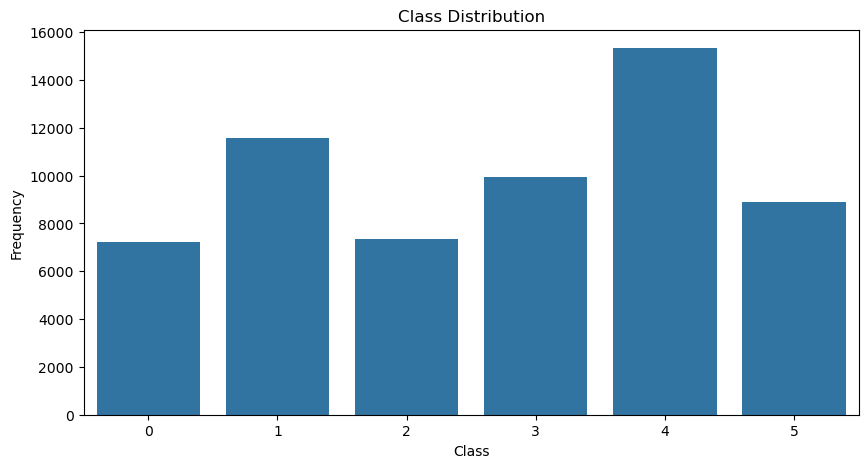

In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.impute import SimpleImputer  # Correct import for imputation
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight
from imblearn.over_sampling import SMOTE
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, BatchNormalization, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from sklearn.metrics import classification_report

def load_data_in_chunks(file_path, chunk_size=1000):
    return pd.read_csv(file_path, engine='python', encoding='utf-8', chunksize=chunk_size)

def preprocess_data(metadata_path, data_path):
    metadata_df = pd.read_csv(metadata_path, sep='\t')
    scRNA_data = pd.concat(load_data_in_chunks(data_path)).transpose()

    metadata_df.index.rename('cell', inplace=True)
    metadata_df.reset_index(inplace=True)
    metadata_df['cell'] = metadata_df['cell'].astype(str).str.split('-').str[0].str.strip().str.upper()
    scRNA_data.reset_index(inplace=True)
    scRNA_data.rename(columns={'index': 'cell'}, inplace=True)
    scRNA_data['cell'] = scRNA_data['cell'].astype(str).str.split('.').str[0].str.strip().str.upper()

    common_cells = set(metadata_df['cell']).intersection(set(scRNA_data['cell']))

    filtered_metadata_df = metadata_df[metadata_df['cell'].isin(common_cells)]
    filtered_scRNA_data = scRNA_data[scRNA_data['cell'].isin(common_cells)]

    merged_data = pd.merge(filtered_scRNA_data, filtered_metadata_df[['cell', 'sample_name', 'sample_type']], on='cell', how='inner')
    if merged_data.empty:
        print("No data was merged. Check cell identifiers and filters.")
        return None

    X = merged_data.drop(columns=['cell', 'sample_name', 'sample_type'])
    y = merged_data['sample_type']
    label_encoder = LabelEncoder()
    y = label_encoder.fit_transform(y)

    # Handle missing values
    imputer = SimpleImputer(strategy='mean')
    X = imputer.fit_transform(X)  # Apply imputation to handle NaNs

    return X, y, merged_data, label_encoder

metadata_path = '/users/barmanjy/Desktop/Persister Cell 2/GSE150949_metaData_with_lineage.txt'
data_path = '/scratch/project_2010376/normalized_GSE150949_pc9_count.csv'

X, y, merged_data, label_encoder = preprocess_data(metadata_path, data_path)

# Proceed with PCA
pca = PCA(n_components=500)
X_reduced = pca.fit_transform(X)

class_counts = np.bincount(y)
plt.figure(figsize=(10, 5))
sns.barplot(x=np.arange(len(class_counts)), y=class_counts)
plt.xlabel('Class')
plt.ylabel('Frequency')
plt.title('Class Distribution')
plt.show()

class_weights = compute_class_weight('balanced', classes=np.unique(y), y=y)
class_weight_dict = dict(enumerate(class_weights))


In [4]:
# Debugging steps to verify data
print("Unique sample types:", merged_data['sample_type'].unique())
print("Sample type distribution:\n", merged_data['sample_type'].value_counts())
print("Merged data shape:", merged_data.shape)
print("First few rows of merged data:\n", merged_data.head())


Unique sample types: ['0' '7' '3' '14_high' '14_med' '14_low']
Sample type distribution:
 sample_type
3          15338
14_high    11571
14_med      9931
7           8891
14_low      7358
0           7226
Name: count, dtype: int64
Merged data shape: (60315, 12397)
First few rows of merged data:
                cell         0         1         2         3         4  \
0  AAACCTGAGACAAGCC -0.046855 -0.006325 -0.364544 -0.428827 -0.008942   
1  AAACCTGAGCAGACTG -0.046855 -0.006325 -0.364544 -0.428827 -0.008942   
2  AAACCTGAGCGAGAAA -0.046855 -0.006325 -0.364544 -0.428827 -0.008942   
3  AAACCTGAGGACAGAA -0.046855 -0.006325 -0.364544 -0.428827 -0.008942   
4  AAACCTGAGGCCGAAT -0.046855 -0.006325 -0.364544  2.032753 -0.008942   

          5         6         7         8  ...     12386     12387     12388  \
0 -0.068597 -0.045149 -0.053783 -0.056811  ...  1.202008 -0.012171 -0.016337   
1 -0.068597 -0.045149 -0.053783 -0.056811  ...  1.244137 -0.012171 -0.016337   
2 -0.068597 -0.045149 -0.

In [ ]:
def create_complex_autoencoder(input_dim, encoding_dim):
    # Encoder
    input_img = Input(shape=(input_dim,))
    x = Dense(2048, activation='relu')(input_img)
    x = BatchNormalization()(x)
    x = Dropout(0.5)(x)
    x = Dense(1024, activation='relu')(x)
    x = BatchNormalization()(x)
    x = Dropout(0.5)(x)
    x = Dense(512, activation='relu')(x)
    x = BatchNormalization()(x)
    x = Dropout(0.5)(x)
    encoded = Dense(encoding_dim, activation='relu')(x)

    # Decoder
    x = Dense(512, activation='relu')(encoded)
    x = BatchNormalization()(x)
    x = Dropout(0.5)(x)
    x = Dense(1024, activation='relu')(x)
    x = BatchNormalization()(x)
    x = Dropout(0.5)(x)
    x = Dense(2048, activation='relu')(x)
    x = BatchNormalization()(x)
    x = Dropout(0.5)(x)
    decoded = Dense(input_dim, activation='sigmoid')(x)

    # Autoencoder
    autoencoder = Model(input_img, decoded)

    # Encoder model
    encoder = Model(input_img, encoded)

    # Compile autoencoder
    autoencoder.compile(optimizer=Adam(learning_rate=1e-3), loss='mse')

    return autoencoder, encoder

def create_ensemble_classifier(input_shape):
    inputs = Input(shape=input_shape)
    x = Dense(512, activation='relu')(inputs)
    x = BatchNormalization()(x)
    x = Dropout(0.5)(x)
    x = Dense(256, activation='relu')(x)
    x = BatchNormalization()(x)
    x = Dropout(0.5)(x)
    x = Dense(128, activation='relu')(x)
    x = BatchNormalization()(x)
    x = Dropout(0.5)(x)
    outputs = Dense(2, activation='softmax')(x)
    model = Model(inputs=inputs, outputs=outputs)
    return model

def model_1():
    # Define the mappings based on sample_type
    non_persister_samples = [0]
    persister_samples = ["7","3","14_high","14_med","14_low"]

    # Update labels: 0 = non-persister, 1 = persister
    y_model1 = np.where(merged_data['sample_type'].isin(persister_samples), 1, 0)

    # Debug statements to check the unique values and their counts
    print("Unique values in y_model1:", np.unique(y_model1, return_counts=True))

    # Ensure there are samples for both classes
    if len(np.unique(y_model1)) != 2:
        print("Not enough classes in y_model1 for Model 1")
        return

    # Oversample the minority class using SMOTE
    smote = SMOTE(random_state=42)
    X_resampled, y_resampled = smote.fit_resample(X_reduced, y_model1)

    # Split the data
    X_train, X_temp, y_train, y_temp = train_test_split(X_resampled, y_resampled, test_size=0.2, random_state=42)
    X_validation, X_test, y_validation, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

    # Scale the data
    scaler = StandardScaler()
    X_train = scaler.fit_transform(X_train)
    X_validation = scaler.transform(X_validation)
    X_test = scaler.transform(X_test)

    # Create and train the autoencoder
    autoencoder, encoder = create_complex_autoencoder(X_train.shape[1], 256)

    early_stopping = EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=True)
    model_checkpoint = ModelCheckpoint('best_complex_autoencoder_model1.keras', save_best_only=True, monitor='val_loss')
    reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=10, min_lr=1e-6)

    autoencoder.fit(X_train, X_train,
                    epochs=300,
                    batch_size=128,  # reduced batch size
                    shuffle=True,
                    validation_data=(X_validation, X_validation),
                    callbacks=[early_stopping, model_checkpoint, reduce_lr],
                    verbose=2)  # increased verbosity

    autoencoder.save('complex_autoencoder_model1.keras')
    encoder.save('complex_encoder_model1.keras')

    X_train_encoded = encoder.predict(X_train)
    X_validation_encoded = encoder.predict(X_validation)
    X_test_encoded = encoder.predict(X_test)

    # Create and train the classifier
    classifier = create_ensemble_classifier((256,))

    classifier.compile(optimizer=Adam(learning_rate=1e-4), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

    early_stopping = EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True)
    model_checkpoint = ModelCheckpoint('best_classifier_model1.keras', save_best_only=True, monitor='val_loss')
    reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=7, min_lr=1e-6)

    classifier.fit(X_train_encoded, y_train,
                   epochs=150,
                   batch_size=128,
                   validation_data=(X_validation_encoded, y_validation),
                   class_weight=class_weight_dict,
                   callbacks=[early_stopping, model_checkpoint, reduce_lr],
                   verbose=2)  # increased verbosity

    classifier.save('classifier_model1.keras')

    # Evaluate the classifier on the test set
    test_loss, test_accuracy = classifier.evaluate(X_test_encoded, y_test)
    print(f"Test Accuracy: {test_accuracy}")

    # Predict the test set
    y_test_pred = classifier.predict(X_test_encoded).argmax(axis=-1)

    # Ensure there are two classes in the target names
    if len(np.unique(y_test_pred)) == 2:
        print(classification_report(y_test, y_test_pred, target_names=['Non-Persister', 'Persister']))

def model_2():
    # Define the mappings based on sample_type
    group1_samples = ['14_high']  # Dint divide
    group2_samples = ['14_med', '14_low']  # Divide

    # Update labels: 0 = Group1 (Dint divide), 1 = Group2 (Divide)
    y_model2 = np.where(merged_data['sample_type'].isin(group1_samples), 0, 1)

    # Debug statements to check the unique values and their counts
    print("Unique values in y_model2:", np.unique(y_model2, return_counts=True))

    # Ensure there are samples for both classes
    if len(np.unique(y_model2)) != 2:
        print("Not enough classes in y_model2 for Model 2")
        return

    # Oversample the minority class using SMOTE
    smote = SMOTE(random_state=42)
    X_resampled, y_resampled = smote.fit_resample(X_reduced, y_model2)

    # Split the data
    X_train, X_temp, y_train, y_temp = train_test_split(X_resampled, y_resampled, test_size=0.2, random_state=42)
    X_validation, X_test, y_validation, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

    # Scale the data
    scaler = StandardScaler()
    X_train = scaler.fit_transform(X_train)
    X_validation = scaler.transform(X_validation)
    X_test = scaler.transform(X_test)

    # Create and train the autoencoder
    autoencoder, encoder = create_complex_autoencoder(X_train.shape[1], 256)

    early_stopping = EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=True)
    model_checkpoint = ModelCheckpoint('best_complex_autoencoder_model2.keras', save_best_only=True, monitor='val_loss')
    reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=10, min_lr=1e-6)

    autoencoder.fit(X_train, X_train,
                    epochs=300,
                    batch_size=128,  # reduced batch size
                    shuffle=True,
                    validation_data=(X_validation, X_validation),
                    callbacks=[early_stopping, model_checkpoint, reduce_lr],
                    verbose=2)  # increased verbosity

    autoencoder.save('complex_autoencoder_model2.keras')
    encoder.save('complex_encoder_model2.keras')

    X_train_encoded = encoder.predict(X_train)
    X_validation_encoded = encoder.predict(X_validation)
    X_test_encoded = encoder.predict(X_test)

    # Create and train the classifier
    classifier = create_ensemble_classifier((256,))

    classifier.compile(optimizer=Adam(learning_rate=1e-4), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

    early_stopping = EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True)
    model_checkpoint = ModelCheckpoint('best_classifier_model2.keras', save_best_only=True, monitor='val_loss')
    reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=7, min_lr=1e-6)

    classifier.fit(X_train_encoded, y_train,
                   epochs=150,
                   batch_size=128,
                   validation_data=(X_validation_encoded, y_validation),
                   class_weight=class_weight_dict,
                   callbacks=[early_stopping, model_checkpoint, reduce_lr],
                   verbose=2)  # increased verbosity

    classifier.save('classifier_model2.keras')

    # Evaluate the classifier on the test set
    test_loss, test_accuracy = classifier.evaluate(X_test_encoded, y_test)
    print(f"Test Accuracy: {test_accuracy}")

    # Predict the test set
    y_test_pred = classifier.predict(X_test_encoded).argmax(axis=-1)

    # Ensure there are two classes in the target names
    if len(np.unique(y_test_pred)) == 2:
        print(classification_report(y_test, y_test_pred, target_names=['Group1 (Dint divide)', 'Group2 (Divide)']))
    else:
        print(f"Only one class {np.unique(y_test_pred)[0]} predicted, classification report is not generated.")

# Execute Model 1
model_1()

# Execute Model 2
model_2()

Unique values in y_model1: (array([0, 1]), array([ 7226, 53089]))


2024-06-27 06:57:20.281828: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:282] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected


Epoch 1/300
664/664 - 21s - 32ms/step - loss: 1.0347 - val_loss: 1.0094 - learning_rate: 0.0010
Epoch 2/300
664/664 - 18s - 27ms/step - loss: 0.9983 - val_loss: 1.0037 - learning_rate: 0.0010
Epoch 3/300
664/664 - 18s - 27ms/step - loss: 0.9941 - val_loss: 0.9987 - learning_rate: 0.0010
Epoch 4/300
664/664 - 18s - 27ms/step - loss: 0.9897 - val_loss: 0.9936 - learning_rate: 0.0010
Epoch 5/300
664/664 - 18s - 27ms/step - loss: 0.9858 - val_loss: 0.9898 - learning_rate: 0.0010
Epoch 6/300
664/664 - 18s - 27ms/step - loss: 0.9828 - val_loss: 0.9862 - learning_rate: 0.0010
Epoch 7/300
664/664 - 18s - 27ms/step - loss: 0.9793 - val_loss: 0.9831 - learning_rate: 0.0010
Epoch 8/300
664/664 - 18s - 27ms/step - loss: 0.9767 - val_loss: 0.9808 - learning_rate: 0.0010
Epoch 9/300
664/664 - 18s - 27ms/step - loss: 0.9738 - val_loss: 0.9774 - learning_rate: 0.0010
Epoch 10/300
664/664 - 18s - 27ms/step - loss: 0.9722 - val_loss: 0.9756 - learning_rate: 0.0010
Epoch 11/300
664/664 - 18s - 27ms/step 